In [6]:
# Sanity check for multi-horizon XGB forecasts vs naive baseline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Configuration ---
# CSV used when running models/train_regression.py
TRAIN_CSV = "../data/crime_dataset_for_test.csv"  # <-- change if needed

# Long-form prediction CSV exported by train_regression.py
PRED_LONG_CSV = "../outputs/hourly_npu_predictions_long_for_streamlit.csv"

# Time-based split used in training script
CUTOFF = pd.Timestamp("2024-01-01 00:00:00")

# Horizons used in training script
HORIZONS = [1, 2, 3, 6, 12, 24]

plt.style.use("seaborn-v0_8-darkgrid")

In [7]:
def build_hourly_panel(df: pd.DataFrame) -> pd.DataFrame:
    """
    Rebuild the hourly NPU panel exactly as in train_regression.py.
    Assumes columns: 'report_date' (datetime-like), 'npu'.
    """
    df = df.copy()

    if "report_date" not in df.columns or "npu" not in df.columns:
        raise RuntimeError("Input CSV must contain 'report_date' and 'npu' columns.")

    df["report_date"] = pd.to_datetime(df["report_date"], errors="coerce")
    df = df.dropna(subset=["report_date", "npu"]).copy()
    df["npu"] = df["npu"].astype(str)

    df["hour"] = df["report_date"].dt.floor("h")

    counts = (
        df.groupby(["npu", "hour"])
        .size()
        .reset_index(name="crime_count")
    )

    all_hours = pd.date_range(
        start=counts["hour"].min().floor("h"),
        end=counts["hour"].max().ceil("h"),
        freq="h",
    )
    npus = counts["npu"].unique()
    idx = pd.MultiIndex.from_product([npus, all_hours], names=["npu", "hour"])

    base = pd.DataFrame(index=idx).reset_index()
    base = base.merge(counts, on=["npu", "hour"], how="left")
    base["crime_count"] = base["crime_count"].fillna(0).astype(int)

    return base


def build_supervised(panel: pd.DataFrame, horizons=None) -> pd.DataFrame:
    """
    Rebuild the supervised table with:
    - lags
    - rolling means
    - multi-horizon targets y_h{h}

    This mirrors build_supervised() in train_regression.py.
    """
    if horizons is None:
        horizons = HORIZONS

    groups = []

    for npu, g in panel.groupby("npu"):
        g = g.sort_values("hour").reset_index(drop=True).copy()

        for lag in [1, 2, 3, 6, 12, 24]:
            g[f"lag_{lag}"] = g["crime_count"].shift(lag)

        for win in [3, 6, 12, 24]:
            g[f"roll_mean_{win}"] = g["crime_count"].shift(1).rolling(win).mean()

        for h in horizons:
            g[f"y_h{h}"] = g["crime_count"].shift(-h)

        groups.append(g)

    full = pd.concat(groups, axis=0, ignore_index=True)
    full = full.dropna().reset_index(drop=True)
    return full


def make_truth_long(supervised: pd.DataFrame, cutoff: pd.Timestamp, horizons=None) -> pd.DataFrame:
    """
    Convert the supervised table into a long-form DataFrame with one row per:
        (npu, reference_hour, horizon_hours, y_true)

    Only keeps rows in the test period (hour >= cutoff) so it aligns with predictions.
    """
    if horizons is None:
        horizons = HORIZONS

    test = supervised[supervised["hour"] >= cutoff].copy()

    long_frames = []
    for h in horizons:
        df_h = test[["npu", "hour", f"y_h{h}"]].copy()
        df_h = df_h.rename(
            columns={
                "hour": "reference_hour",
                f"y_h{h}": "y_true",
            }
        )
        df_h["horizon_hours"] = h
        long_frames.append(df_h)

    truth_long = pd.concat(long_frames, axis=0, ignore_index=True)
    return truth_long

In [8]:
# --- 1. Load the training CSV and rebuild the supervised test set ---
df_raw = pd.read_csv(TRAIN_CSV, low_memory=False)

panel = build_hourly_panel(df_raw)
supervised = build_supervised(panel, horizons=HORIZONS)

print(f"Supervised table shape: {supervised.shape}")
print(
    f"Hour range: {supervised['hour'].min()} -> {supervised['hour'].max()}"
)

# Build long-form ground truth for the test period (hour >= CUTOFF)
truth_long = make_truth_long(supervised, CUTOFF, horizons=HORIZONS)

print(f"Truth long rows: {len(truth_long):,}")
truth_long.head()

Supervised table shape: (874975, 19)
Hour range: 2021-01-02 13:00:00 -> 2024-12-30 19:00:00
Truth long rows: 1,313,400


,npu,reference_hour,y_true,horizon_hours
0,A,2024-01-01 00:00:00,0.0,1
1,A,2024-01-01 01:00:00,0.0,1
2,A,2024-01-01 02:00:00,0.0,1
3,A,2024-01-01 03:00:00,0.0,1
4,A,2024-01-01 04:00:00,0.0,1


In [9]:
# --- 2. Load model/baseline predictions (long form) and merge with truth ---

pred = pd.read_csv(
    PRED_LONG_CSV,
    parse_dates=["reference_hour", "forecast_hour"],
)

print(f"Pred long rows: {len(pred):,}")
print(pred.head())

# Merge on (npu, reference_hour, horizon_hours)
merged = pred.merge(
    truth_long,
    on=["npu", "reference_hour", "horizon_hours"],
    how="inner",
)

print(f"Merged rows: {len(merged):,}")

# Sanity: merged should have same number of rows as predictions;
# if not, inspect why (e.g., cutoff mismatch).
if len(merged) != len(pred):
    print(
        "WARNING: merged rows != prediction rows. "
        "Check that TRAIN_CSV and PRED_LONG_CSV come from the same run."
    )
else:
    print("OK: merged rows match prediction rows.")

Pred long rows: 1,310,400
  npu      reference_hour  crime_count_at_reference  pred_model  \
0   A 2024-01-01 00:00:00                         0    0.020516   
1   A 2024-01-01 01:00:00                         0    0.014844   
2   A 2024-01-01 02:00:00                         0    0.010801   
3   A 2024-01-01 03:00:00                         0    0.011075   
4   A 2024-01-01 04:00:00                         0    0.011266   

   horizon_hours       forecast_hour  baseline_pred  
0              1 2024-01-01 01:00:00              0  
1              1 2024-01-01 02:00:00              0  
2              1 2024-01-01 03:00:00              0  
3              1 2024-01-01 04:00:00              0  
4              1 2024-01-01 05:00:00              0  
Merged rows: 1,310,400
OK: merged rows match prediction rows.


In [10]:
rows = []

for h in HORIZONS:
    sub = merged[merged["horizon_hours"] == h].copy()
    if sub.empty:
        continue

    y_true = sub["y_true"].to_numpy()
    y_model = sub["pred_model"].to_numpy()
    y_base = sub["baseline_pred"].to_numpy()

    mse_model = mean_squared_error(y_true, y_model)
    rmse_model = np.sqrt(mse_model)
    mae_model = mean_absolute_error(y_true, y_model)
    r2_model = r2_score(y_true, y_model)

    mse_base = mean_squared_error(y_true, y_base)
    rmse_base = np.sqrt(mse_base)
    mae_base = mean_absolute_error(y_true, y_base)
    r2_base = r2_score(y_true, y_base)

    skill_rmse = np.nan
    skill_mae = np.nan
    if rmse_base > 0:
        skill_rmse = 1.0 - rmse_model / rmse_base
    if mae_base > 0:
        skill_mae = 1.0 - mae_model / mae_base

    rows.append(
        {
            "horizon_h": h,
            "rmse_model": rmse_model,
            "mae_model": mae_model,
            "r2_model": r2_model,
            "rmse_baseline": rmse_base,
            "mae_baseline": mae_base,
            "r2_baseline": r2_base,
            "skill_rmse": skill_rmse,
            "skill_mae": skill_mae,
        }
    )

metrics_df = pd.DataFrame(rows)

metrics_df = metrics_df.sort_values("horizon_h").reset_index(drop=True)
display(metrics_df)

print("\nAverages across horizons:")
print(
    metrics_df[
        ["rmse_model", "rmse_baseline", "mae_model", "mae_baseline",
         "r2_model", "r2_baseline", "skill_rmse", "skill_mae"]
    ].mean()
)

,horizon_h,rmse_model,mae_model,r2_model,rmse_baseline,mae_baseline,r2_baseline,skill_rmse,skill_mae
0,1,0.155557,0.043964,0.009815,0.217145,0.044835,-0.929463,0.283626,0.019433
1,2,0.155604,0.043976,0.009391,0.217934,0.045124,-0.943169,0.286004,0.025425
2,3,0.155617,0.043941,0.009408,0.218239,0.045247,-0.948253,0.286942,0.028871
3,6,0.155661,0.043955,0.008493,0.219473,0.045678,-0.971058,0.290752,0.037713
4,12,0.155689,0.043921,0.008130,0.220659,0.046181,-0.992417,0.294435,0.048938
5,24,0.155679,0.044019,0.008618,0.218092,0.045183,-0.945631,0.286177,0.025770



Averages across horizons:
rmse_model       0.155635
rmse_baseline    0.218590
mae_model        0.043963
mae_baseline     0.045375
r2_model         0.008976
r2_baseline     -0.954999
skill_rmse       0.287989
skill_mae        0.031025
dtype: float64


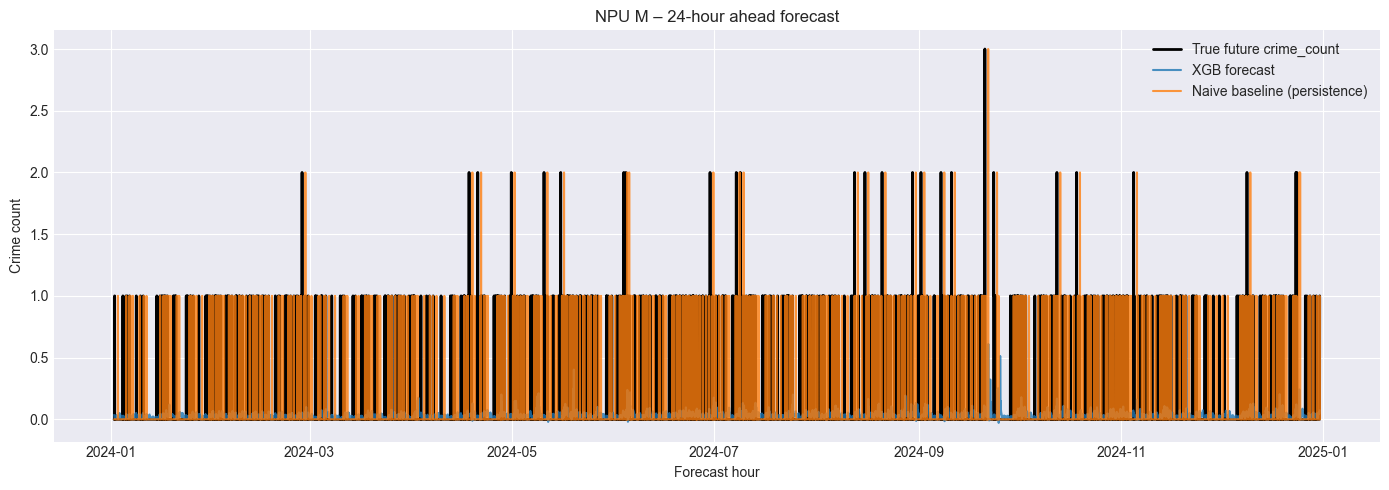

In [21]:
# --- 3. Visual sanity check for one NPU and one horizon ---

# Choose NPU id and horizon to inspect
npu_id = "M"     # e.g. campus NPU, adjust as needed
h_plot = 24   # 1, 3, 6, 12, 24

sub = merged[
    (merged["npu"] == npu_id) &
    (merged["horizon_hours"] == h_plot)
].copy()

if sub.empty:
    print(f"No rows found for NPU={npu_id}, horizon={h_plot}h")
else:
    sub = sub.sort_values("forecast_hour")

    plt.figure(figsize=(14, 5))
    plt.plot(
        sub["forecast_hour"],
        sub["y_true"],
        label="True future crime_count",
        color="black",
        linewidth=2,
    )
    plt.plot(
        sub["forecast_hour"],
        sub["pred_model"],
        label="XGB forecast",
        color="tab:blue",
        alpha=0.8,
    )
    plt.plot(
        sub["forecast_hour"],
        sub["baseline_pred"],
        label="Naive baseline (persistence)",
        color="tab:orange",
        alpha=0.8,
    )

    plt.title(f"NPU {npu_id} – {h_plot}-hour ahead forecast")
    plt.xlabel("Forecast hour")
    plt.ylabel("Crime count")
    plt.legend()
    plt.tight_layout()
    plt.show()